In [2]:
import pandas as pd
import numpy as np
from pycaret.regression import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import files

# Upload files manually in Google Colab
uploaded = files.upload()
uploaded = files.upload()
# Load datasets (ensure correct files are selected)
sentiment_df = pd.read_csv("train_stockemo.csv")
stock_df = pd.read_csv("merged_stock_prices.csv")




Saving merged_stock_prices.csv to merged_stock_prices.csv


Saving train_stockemo.csv to train_stockemo (1).csv


,Description,Value
0,Session id,42
1,Target,Close
2,Target type,Regression
3,Original data shape,"(996, 8)"
4,Transformed data shape,"(996, 8)"
5,Transformed train set shape,"(697, 8)"
6,Transformed test set shape,"(299, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.1539,0.1525,0.3730,0.9997,0.0044,0.0017,0.1620
xgboost,Extreme Gradient Boosting,0.1736,0.2556,0.4791,0.9994,0.0058,0.0020,0.1800
rf,Random Forest Regressor,0.2500,0.2901,0.5215,0.9993,0.0062,0.0029,0.2740
lightgbm,Light Gradient Boosting Machine,0.3068,0.3258,0.5594,0.9992,0.0070,0.0035,0.1660
gbr,Gradient Boosting Regressor,0.4292,0.4513,0.6518,0.9990,0.0071,0.0045,0.1540
dt,Decision Tree Regressor,0.1819,0.4607,0.6397,0.9990,0.0074,0.0021,0.0220
br,Bayesian Ridge,0.8553,1.4036,1.1770,0.9967,0.0123,0.0086,0.0220
huber,Huber Regressor,0.8440,1.4287,1.1853,0.9967,0.0123,0.0085,0.0680
lar,Least Angle Regression,0.8554,1.4034,1.1768,0.9967,0.0123,0.0086,0.0240
lr,Linear Regression,0.8554,1.4034,1.1768,0.9967,0.0123,0.0086,0.7740


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [3]:
# Standardize column names
sentiment_df.rename(columns={'Date': 'date', 'Stock': 'ticker'}, inplace=True)
stock_df.rename(columns={'Date': 'date', 'Stock': 'ticker'}, inplace=True)

# Convert timestamps to datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
stock_df['date'] = pd.to_datetime(stock_df['date'])

# Filter for AAPL ticker
sentiment_df = sentiment_df[sentiment_df['ticker'] == 'AAPL'].copy()
stock_df = stock_df[stock_df['ticker'] == 'AAPL'].copy()

# Custom mapping for emotion labels
emotion_mapping = {
    'ambiguous': 0,
    'amusement': 2,
    'anger': -2,
    'anxiety': -3,
    'belief': 1,
    'confusion': -1,
    'depression': -3,
    'disgust': -2,
    'excitement': 3,
    'optimism': 3,
    'panic': -3,
    'surprise': 1
}

# Map emotions to numerical values
sentiment_df.loc[:, 'sentiment_score'] = sentiment_df['emo_label'].map(emotion_mapping)

# Merge sentiment data with stock prices
merged_df = pd.merge(stock_df, sentiment_df[['date', 'sentiment_score']], on=['date'], how='inner')

# Feature Engineering: Moving Averages
merged_df['MA_10'] = merged_df['Close'].rolling(window=10).mean()
merged_df['MA_50'] = merged_df['Close'].rolling(window=50).mean()

# Drop NaN values after rolling calculations
merged_df.dropna(inplace=True)

# Define Features and Target
features = ['Open', 'High', 'Low', 'Volume', 'MA_10', 'MA_50', 'sentiment_score']  # Use mapped sentiment score
target = 'Close'  # Predicting closing price

X = merged_df[features]
y = merged_df[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert back to DataFrame for PyCaret
X_train_df = pd.DataFrame(X_train, columns=features)
X_train_df[target] = y_train.reset_index(drop=True)

# Initialize PyCaret AutoML
exp_reg = setup(data=X_train_df, target=target, session_id=42)

# Run AutoML
best_model = compare_models()

# Finalize model
final_model = finalize_model(best_model)

# Convert X_test back to DataFrame with correct column names
X_test_df = pd.DataFrame(X_test, columns=features)

# Evaluate Model
predictions = predict_model(final_model, data=X_test_df)
print(predictions.head())

,Description,Value
0,Session id,42
1,Target,Close
2,Target type,Regression
3,Original data shape,"(996, 8)"
4,Transformed data shape,"(996, 8)"
5,Transformed train set shape,"(697, 8)"
6,Transformed test set shape,"(299, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.1539,0.1525,0.3730,0.9997,0.0044,0.0017,0.1870
xgboost,Extreme Gradient Boosting,0.1736,0.2556,0.4791,0.9994,0.0058,0.0020,0.1010
rf,Random Forest Regressor,0.2500,0.2901,0.5215,0.9993,0.0062,0.0029,0.2760
lightgbm,Light Gradient Boosting Machine,0.3068,0.3258,0.5594,0.9992,0.0070,0.0035,0.1430
gbr,Gradient Boosting Regressor,0.4292,0.4513,0.6518,0.9990,0.0071,0.0045,0.1390
dt,Decision Tree Regressor,0.1819,0.4607,0.6397,0.9990,0.0074,0.0021,0.0240
br,Bayesian Ridge,0.8553,1.4036,1.1770,0.9967,0.0123,0.0086,0.0230
huber,Huber Regressor,0.8440,1.4287,1.1853,0.9967,0.0123,0.0085,0.0460
lar,Least Angle Regression,0.8554,1.4034,1.1768,0.9967,0.0123,0.0086,0.0390
lr,Linear Regression,0.8554,1.4034,1.1768,0.9967,0.0123,0.0086,0.0250


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

       Open      High       Low    Volume     MA_10     MA_50  \
0  0.457171  0.400955  0.353490 -0.148292  0.385659  0.507631   
1  0.260956  0.362366  0.343629  0.129831  0.430165  0.215280   
2  0.580601  0.608649  0.667114 -1.032431  0.585780  0.478093   
3 -0.641445 -0.686258 -0.638516  0.003389 -0.675420 -0.894099   
4 -0.653223 -0.643893 -0.592861  0.255256 -0.763432 -0.966158   

   sentiment_score  prediction_label  
0        -0.103256        112.000000  
1         0.753768        113.883471  
2        -0.103256        119.485398  
3         1.182280         90.310124  
4         1.182280         91.632500  


,Description,Value
0,Session id,42
1,Target,Close
2,Target type,Regression
3,Original data shape,"(996, 8)"
4,Transformed data shape,"(996, 8)"
5,Transformed train set shape,"(697, 8)"
6,Transformed test set shape,"(299, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.1539,0.1525,0.3730,0.9997,0.0044,0.0017,0.2820
xgboost,Extreme Gradient Boosting,0.1736,0.2556,0.4791,0.9994,0.0058,0.0020,0.1220
rf,Random Forest Regressor,0.2500,0.2901,0.5215,0.9993,0.0062,0.0029,0.2820
lightgbm,Light Gradient Boosting Machine,0.3068,0.3258,0.5594,0.9992,0.0070,0.0035,0.2590
gbr,Gradient Boosting Regressor,0.4292,0.4513,0.6518,0.9990,0.0071,0.0045,0.1480
dt,Decision Tree Regressor,0.1819,0.4607,0.6397,0.9990,0.0074,0.0021,0.0250
br,Bayesian Ridge,0.8553,1.4036,1.1770,0.9967,0.0123,0.0086,0.0240
huber,Huber Regressor,0.8440,1.4287,1.1853,0.9967,0.0123,0.0085,0.0450
lar,Least Angle Regression,0.8554,1.4034,1.1768,0.9967,0.0123,0.0086,0.0430
lr,Linear Regression,0.8554,1.4034,1.1768,0.9967,0.0123,0.0086,0.6870


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

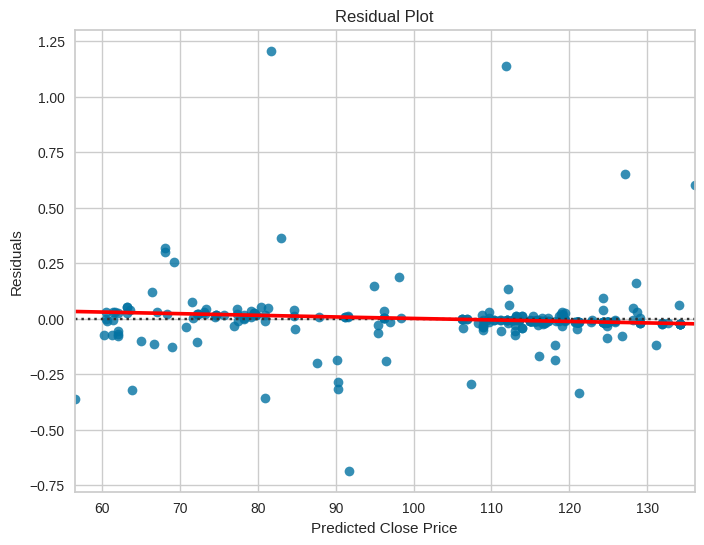

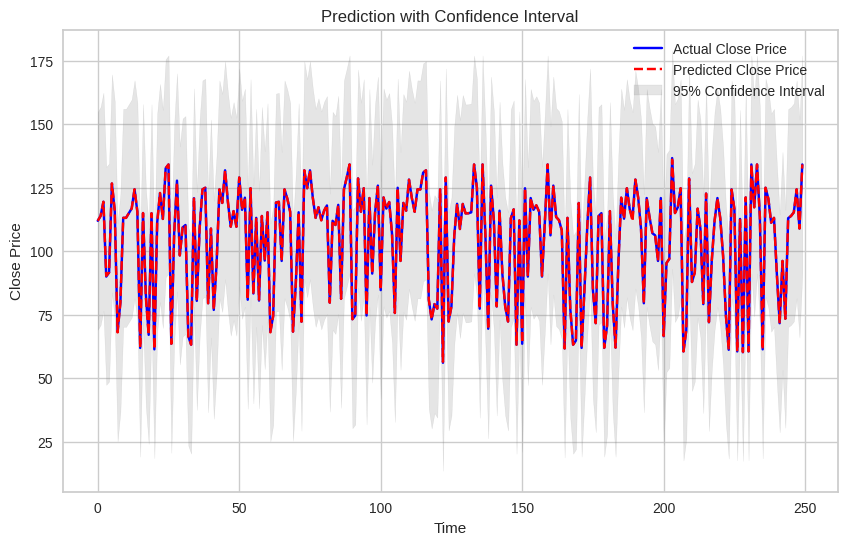

In [6]:
# Define Features and Target
features = ['Open', 'High', 'Low', 'Volume', 'MA_10', 'MA_50', 'sentiment_score']  # Use mapped sentiment score
target = 'Close'  # Predicting closing price

X = merged_df[features]
y = merged_df[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert back to DataFrame for PyCaret
X_train_df = pd.DataFrame(X_train, columns=features)
X_train_df[target] = y_train.reset_index(drop=True)

# Initialize PyCaret AutoML
exp_reg = setup(data=X_train_df, target=target, session_id=42)

# Run AutoML
best_model = compare_models()

# Finalize model
final_model = finalize_model(best_model)

# Convert X_test back to DataFrame with correct column names
X_test_df = pd.DataFrame(X_test, columns=features)

# Evaluate Model
predictions = predict_model(final_model, data=X_test_df)

# Ensure the correct column name for predictions
pred_col = 'prediction_label' if 'prediction_label' in predictions.columns else 'Label'

# Residual Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=predictions[pred_col], y=y_test, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Predicted Close Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Confidence Interval Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Close Price', color='blue')
plt.plot(predictions[pred_col], label='Predicted Close Price', color='red', linestyle='dashed')
plt.fill_between(range(len(y_test)),
                 predictions[pred_col] - 1.96 * predictions[pred_col].std(),
                 predictions[pred_col] + 1.96 * predictions[pred_col].std(),
                 color='gray', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.title("Prediction with Confidence Interval")
plt.show()


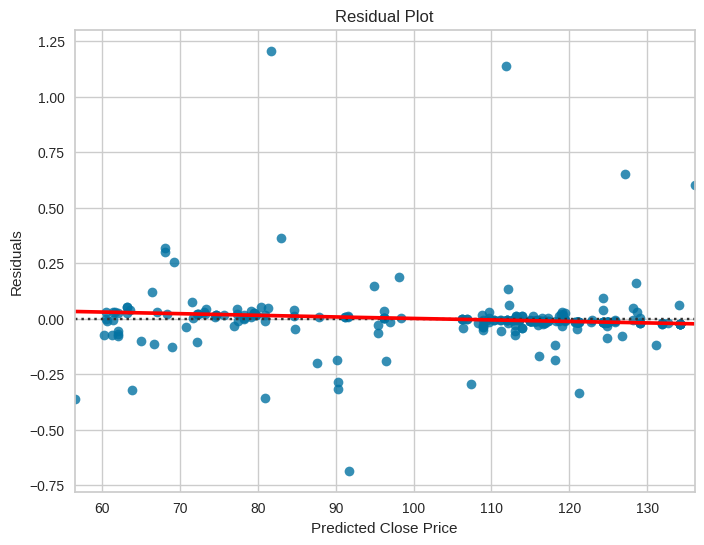

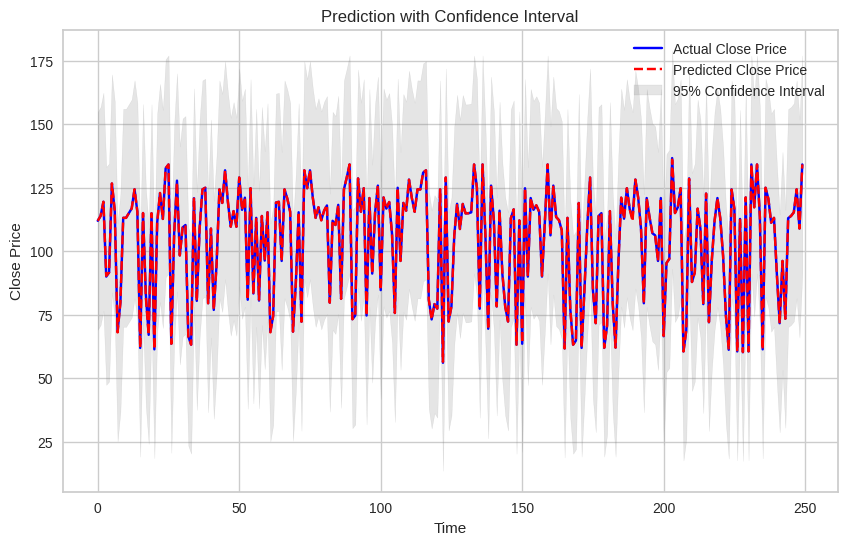

Mean Absolute Error (MAE): 0.05306456970214984
Mean Squared Error (MSE): 0.02292076648697909
Root Mean Squared Error (RMSE): 0.15139605836011416
R-squared (R2): 0.9999520421588884


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the correct column name for predictions
pred_col = 'prediction_label' if 'prediction_label' in predictions.columns else 'Label'

# Residual Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=predictions[pred_col], y=y_test, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Predicted Close Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Confidence Interval Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Close Price', color='blue', linestyle='solid')  # Ensure solid line
plt.plot(predictions[pred_col].values, label='Predicted Close Price', color='red', linestyle='dashed')
plt.fill_between(range(len(y_test)),
                 predictions[pred_col] - 1.96 * predictions[pred_col].std(),
                 predictions[pred_col] + 1.96 * predictions[pred_col].std(),
                 color='gray', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.title("Prediction with Confidence Interval")
plt.show()

# Error Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, predictions[pred_col])
mse = mean_squared_error(y_test, predictions[pred_col])
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions[pred_col])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

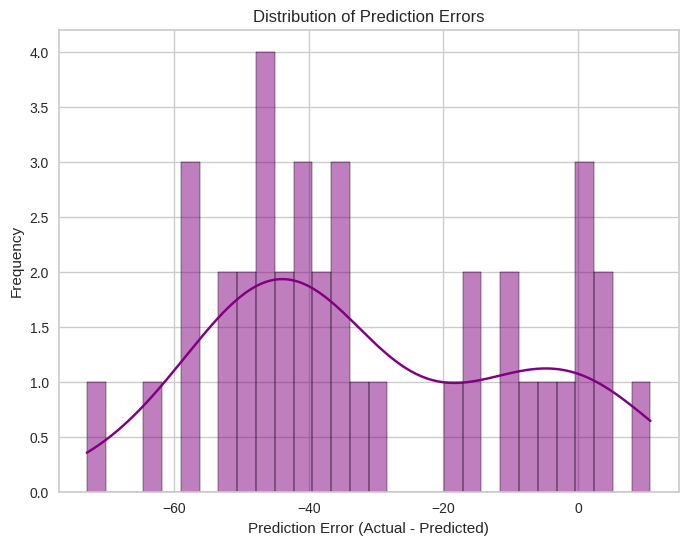

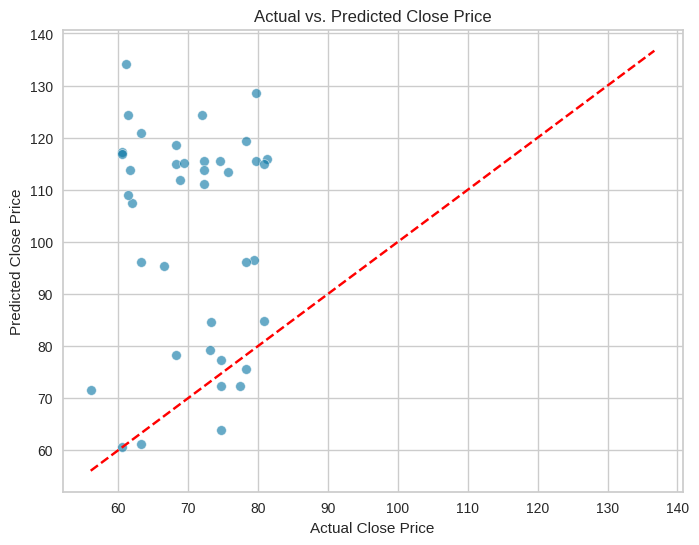

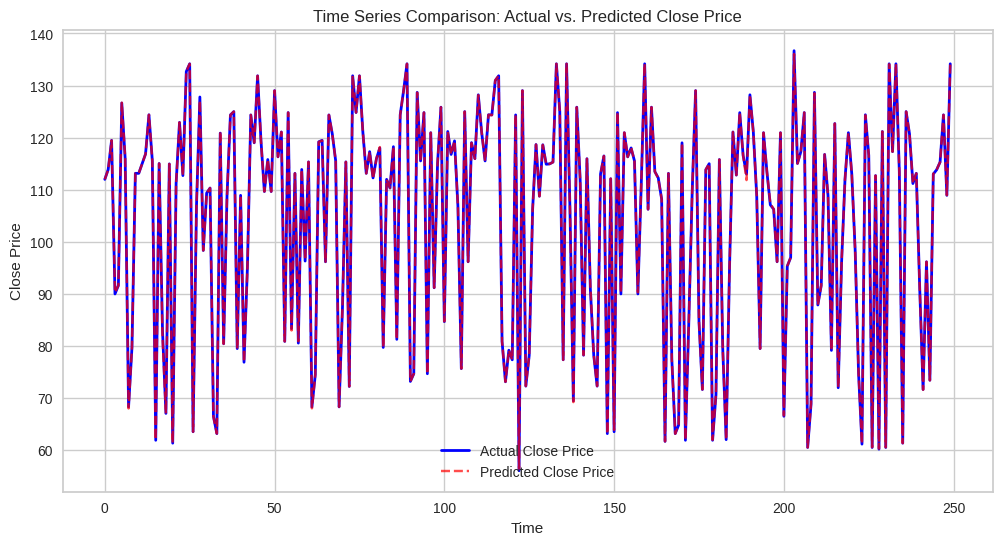

In [10]:

# Distribution of Prediction Errors (Histogram)
plt.figure(figsize=(8, 6))
sns.histplot(y_test - predictions[pred_col], bins=30, kde=True, color='purple')
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

# Scatter Plot of Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=predictions[pred_col], alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='dashed', color='red')  # 45-degree line
plt.xlabel("Actual Close Price")
plt.ylabel("Predicted Close Price")
plt.title("Actual vs. Predicted Close Price")
plt.show()

# Time Series Comparison Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Close Price', color='blue', linestyle='solid', linewidth=2)
plt.plot(predictions[pred_col].values, label='Predicted Close Price', color='red', linestyle='dashed', alpha=0.7)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.title("Time Series Comparison: Actual vs. Predicted Close Price")
plt.show()


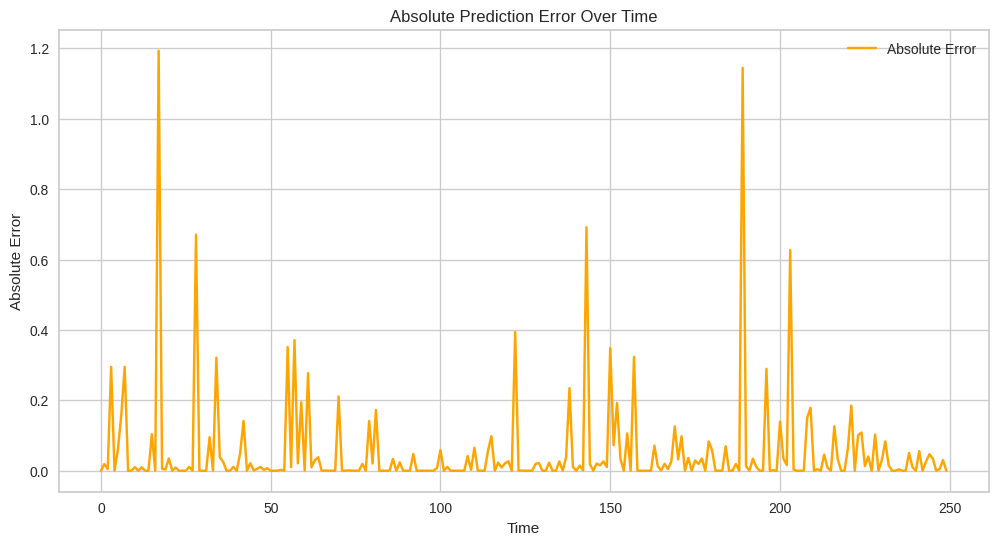

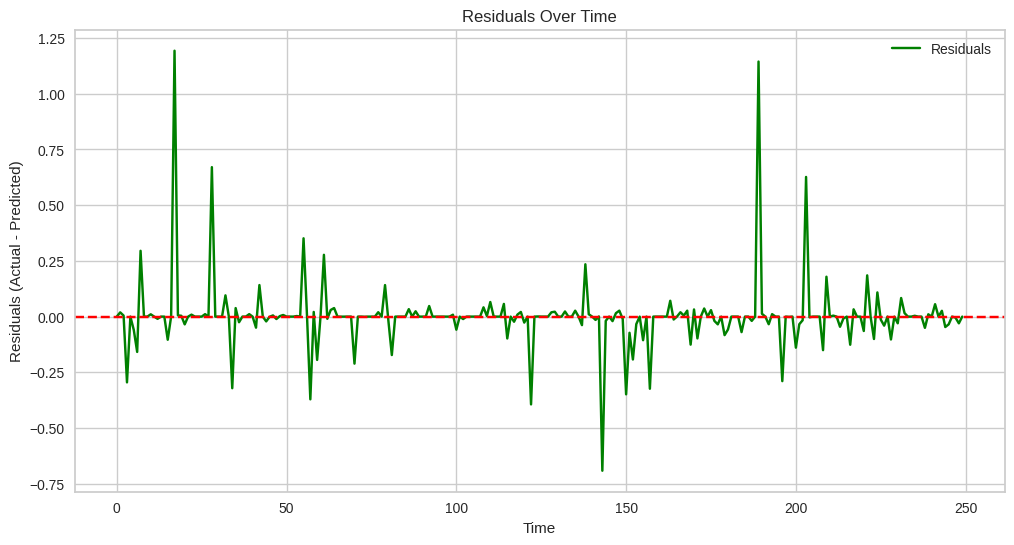

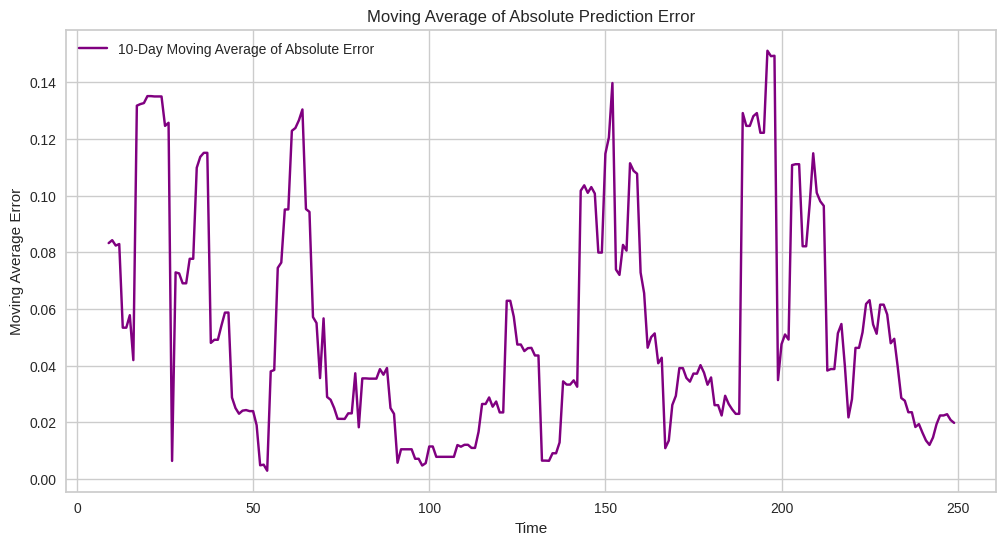

In [11]:

# Absolute Error Over Time
plt.figure(figsize=(12, 6))
plt.plot(abs(y_test.values - predictions[pred_col].values), color='orange', label='Absolute Error')
plt.xlabel("Time")
plt.ylabel("Absolute Error")
plt.title("Absolute Prediction Error Over Time")
plt.legend()
plt.show()

# Residuals Over Time
plt.figure(figsize=(12, 6))
plt.plot(y_test.values - predictions[pred_col].values, color='green', label='Residuals')
plt.axhline(y=0, color='red', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals Over Time")
plt.legend()
plt.show()

# Moving Average of Prediction Errors
rolling_error = abs(y_test.values - predictions[pred_col].values)
rolling_mean = pd.Series(rolling_error).rolling(window=10).mean()
plt.figure(figsize=(12, 6))
plt.plot(rolling_mean, color='purple', label='10-Day Moving Average of Absolute Error')
plt.xlabel("Time")
plt.ylabel("Moving Average Error")
plt.title("Moving Average of Absolute Prediction Error")
plt.legend()
plt.show()

Normality Test Statistic: nan, p-value: nan
Residuals do not appear to be normally distributed (reject H0)


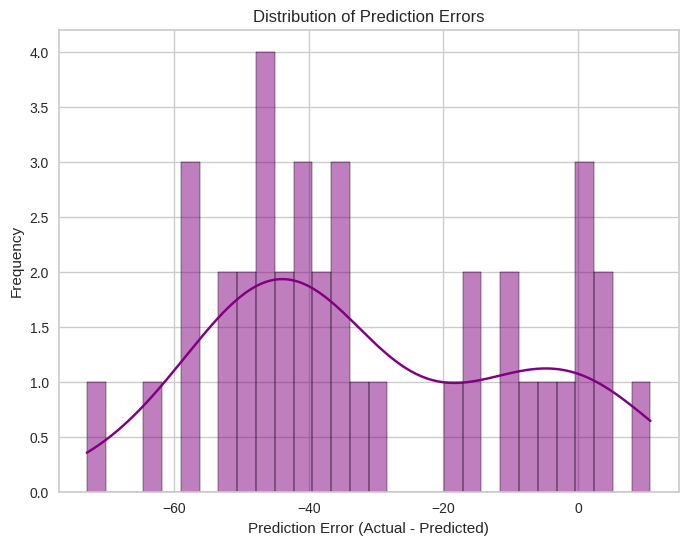

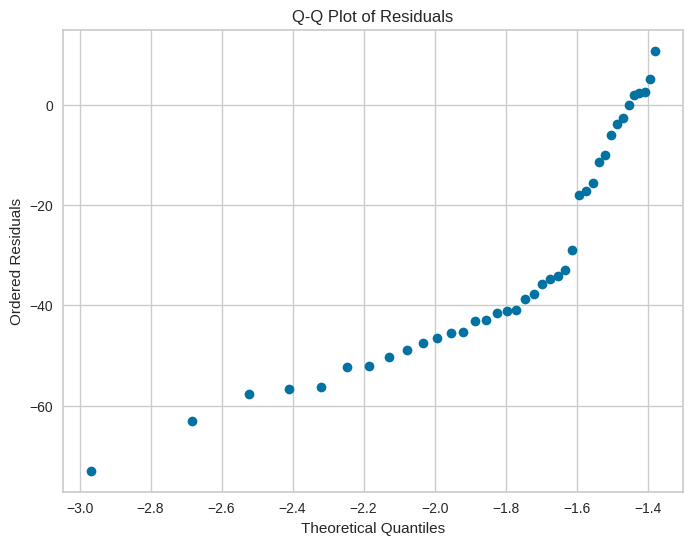

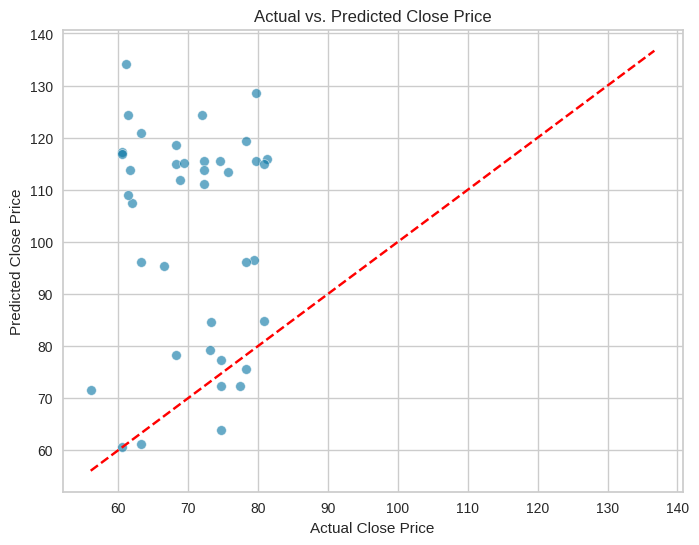

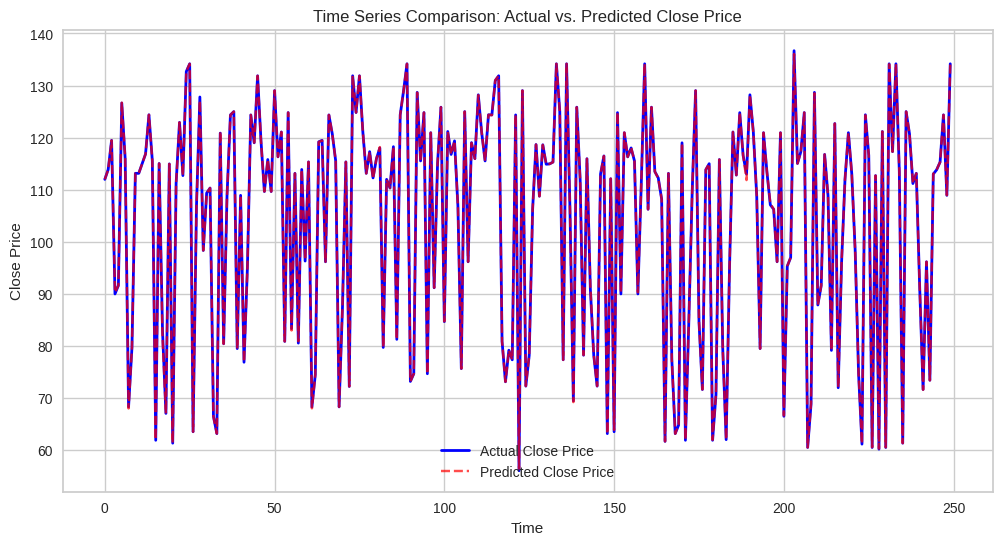

In [14]:

import scipy.stats as stats
from scipy.stats import normaltest
# Normality Test for Residuals
residuals = y_test - predictions[pred_col]
stat, p = normaltest(residuals)
print(f"Normality Test Statistic: {stat}, p-value: {p}")
if p > 0.05:
    print("Residuals appear to be normally distributed (fail to reject H0)")
else:
    print("Residuals do not appear to be normally distributed (reject H0)")

# Distribution of Prediction Errors (Histogram)
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

# Q-Q Plot to Check Normality of Residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Residuals")
plt.show()

# Scatter Plot of Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=predictions[pred_col], alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='dashed', color='red')  # 45-degree line
plt.xlabel("Actual Close Price")
plt.ylabel("Predicted Close Price")
plt.title("Actual vs. Predicted Close Price")
plt.show()

# Time Series Comparison Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Close Price', color='blue', linestyle='solid', linewidth=2)
plt.plot(predictions[pred_col].values, label='Predicted Close Price', color='red', linestyle='dashed', alpha=0.7)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.title("Time Series Comparison: Actual vs. Predicted Close Price")
plt.show()

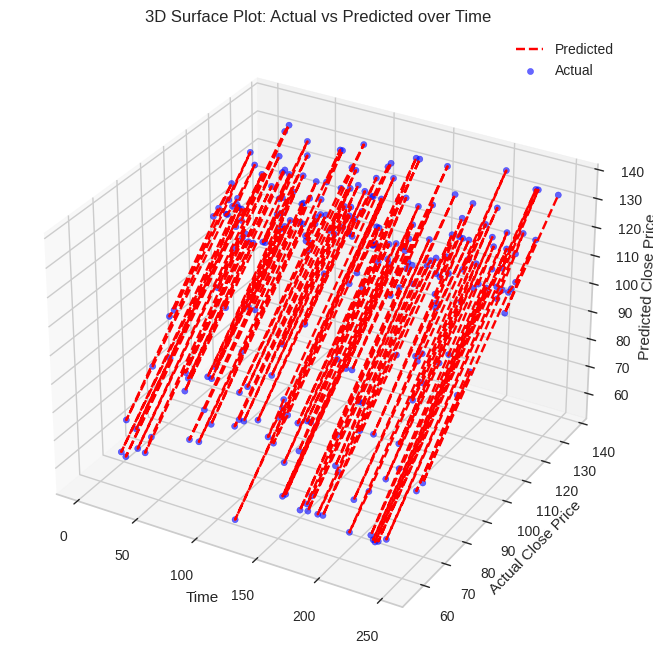

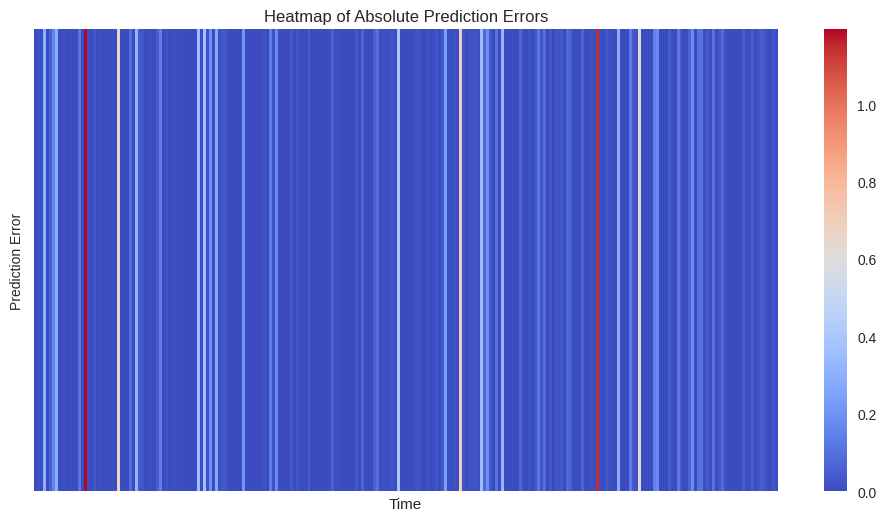

In [15]:
# Ensure the correct column name for predictions
pred_col = 'prediction_label' if 'prediction_label' in predictions.columns else 'Label'

# 3D Surface Plot: Time vs Actual vs Predicted
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
time = np.arange(len(y_test))
ax.plot(time, y_test.values, predictions[pred_col].values, label='Predicted', color='red', linestyle='dashed')
ax.scatter(time, y_test.values, predictions[pred_col].values, color='blue', label='Actual', alpha=0.6)
ax.set_xlabel("Time")
ax.set_ylabel("Actual Close Price")
ax.set_zlabel("Predicted Close Price")
ax.set_title("3D Surface Plot: Actual vs Predicted over Time")
ax.legend()
plt.show()

# Heatmap of Prediction Errors
error_matrix = np.abs(y_test.values.reshape(-1, 1) - predictions[pred_col].values.reshape(-1, 1))
plt.figure(figsize=(12, 6))
sns.heatmap(error_matrix.T, cmap='coolwarm', cbar=True, xticklabels=False, yticklabels=["Prediction Error"])
plt.xlabel("Time")
plt.title("Heatmap of Absolute Prediction Errors")
plt.show()

In [2]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 56.6 MB/s eta 0:00:00
   ━━━━━